<a href="https://colab.research.google.com/github/djsg2021utec/TESIS_MAESTRIA/blob/main/ViVIT_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
from tqdm import tqdm
import time
import os
from base64 import b64encode
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode
import glob
from random import shuffle
import tensorflow as tf
import torch
import shutil
import sys
from torch.utils.data import DataLoader, TensorDataset, random_split

# %pip install tensorboard torchvision
# from torch.utils.tensorboard import SummaryWriter

### Extraer los videos

In [35]:
# @title Descargar bases de datos
# @markdown ## **Real World Fights 2000**

# @markdown #### Una base de datos con 2000 videos capturados por medio de cámaras de videovigilancia en el mundo real. Introducido por [Cheng 2019](https://paperswithcode.com/paper/rwf-2000-an-open-large-scale-video-database).

# Enlace del repositorio donde está alojandos los datos
# https://github.com/mchengny/RWF2000-Video-Database-for-Violence-Detection

# @markdown ## **Ingrese las direcciones de los ZIP** :
RWF_2000_1_url = "https://drive.google.com/uc?id=1nQ9IR3cGc4NEDOXhPQ89id8je8Uj2VUc" # @param {type:"string"}
RWF_2000_2_url = "https://drive.google.com/uc?id=1w9G_Z7gkXZzK4DImdI8wanyjs22fQARO" # @param {type:"string"}
RWF_2000_3_url = "https://drive.google.com/uc?id=15LhjavoUsLS01CPkc3qav0rJxBc9d4nl" # @param {type:"string"}
# @markdown ---


# ********************************************************************
# Descargando los fragmentos del archivo ZIP de la data RWF-2000.zip
# ********************************************************************
if not os.path.exists('/content/RWF-2000'):
  download_links = [
      RWF_2000_1_url,
      RWF_2000_2_url,
      RWF_2000_3_url
  ]

  for link in tqdm(download_links, desc="Descargando fragmentos"):
      !gdown {link}
  # ********************************************************************
  # Juntando los fragmentos del archivo ZIP de la data RWF-2000.zip
  # ********************************************************************
  !cat RWF-2000.zip.001 RWF-2000.zip.002 RWF-2000.zip.003 > RWF-2000.zip

  # Eliminando los fragmentos
  for fragment in tqdm(["RWF-2000.zip.001", "RWF-2000.zip.002", "RWF-2000.zip.003"], desc="Eliminando fragmentos"):
      !rm /content/{fragment}

  # Descomprimiendo los archivos en el directorio RWF-2000
  !unzip "/content/RWF-2000.zip" -d "/content/"

  # Eliminando RWF-2000.zip
  !rm /content/RWF-2000.zip

  # Asegurar que la memoria RAM se liberó
  import gc
  gc.collect()

  time.sleep(10)

# ******************************************************************
# Se crea un dataframe para manejar fácilmente los datos de RWF-2000
# ******************************************************************
carpeta = '/content/RWF-2000'
lista_carpetas_avi = [
    {'ruta': f'{carpeta}/train/Fight', 'data': 'train', 'etiqueta':'Fight'},
    {'ruta': f'{carpeta}/train/NonFight', 'data': 'train', 'etiqueta':'NonFight'},
    {'ruta': f'{carpeta}/val/Fight', 'data': 'val', 'etiqueta':'Fight'},
    {'ruta': f'{carpeta}/val/NonFight', 'data': 'val', 'etiqueta':'NonFight'}
]
lista_archivos_avi = []
for carpeta in lista_carpetas_avi:
  ruta_carpeta=carpeta['ruta']
  tipo_data =carpeta['data']
  etiqueta_data =carpeta['etiqueta']
  for filename in os.listdir(ruta_carpeta):
      if filename.endswith(".avi"):
        registro_archivo = {'ruta': f'{ruta_carpeta}/{filename}', 'data': f'{tipo_data}', 'etiqueta':f'{etiqueta_data}'}
        lista_archivos_avi.append(registro_archivo)

videos_RWF2000_df = pd.DataFrame(lista_archivos_avi)
print("Se creó el dataframe: videos_RWF2000_df")


Se creó el dataframe: videos_RWF2000_df


### Resumen de las bases de datos

In [42]:
# @markdown **Funciones de los histogramas**
# Histograma de los frames que tienen los videos
import pandas as pd
import matplotlib.pyplot as plt

fps = True # @param {type:"boolean"}
total_frames = True # @param {type:"boolean"}

def histograms_in_videos(videos_df):
    list_fps = []
    list_total_frames = []
    number_items = videos_df.shape[0]  # Aquí cambié 'videos_RWF2000_df' por 'videos_df'

    for i in range(number_items):
        video_path = videos_df['ruta'][i]
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        list_fps.append(fps)
        list_total_frames.append(total_frames)

    return list_fps,list_total_frames

def plot_histograms(list_fps, list_total_frames, database_name = "RWF_2000"):
    """Función para graficar histogramas de FPS y número total de frames."""

    # Crear una figura y dos subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Datos y configuraciones para cada subplot
    data_list = [list_fps, list_total_frames]
    titles = [f'Histograma de FPS en videos de la data {database_name}', f'Histograma de Número total de frames de la data {database_name}']
    xlabels = ['FPS', 'Número total de frames']
    ylabels = ['Número de videos', 'Número de videos']

    # Bucle para crear y configurar cada histograma
    for i, ax in enumerate(axs):
        ax.hist(data_list[i], bins=30, edgecolor='black', alpha=0.7)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Ajustar el espacio entre los subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


#### RWF-2000

In [4]:
# Descripción general de los datos
videos_RWF2000_df.describe()

,ruta,data,etiqueta
count,2000,2000,2000
unique,2000,2,2
top,/content/RWF-2000/train/Fight/хдзщЩЖчРЖхПСх║Чх...,train,Fight
freq,1,1600,1000


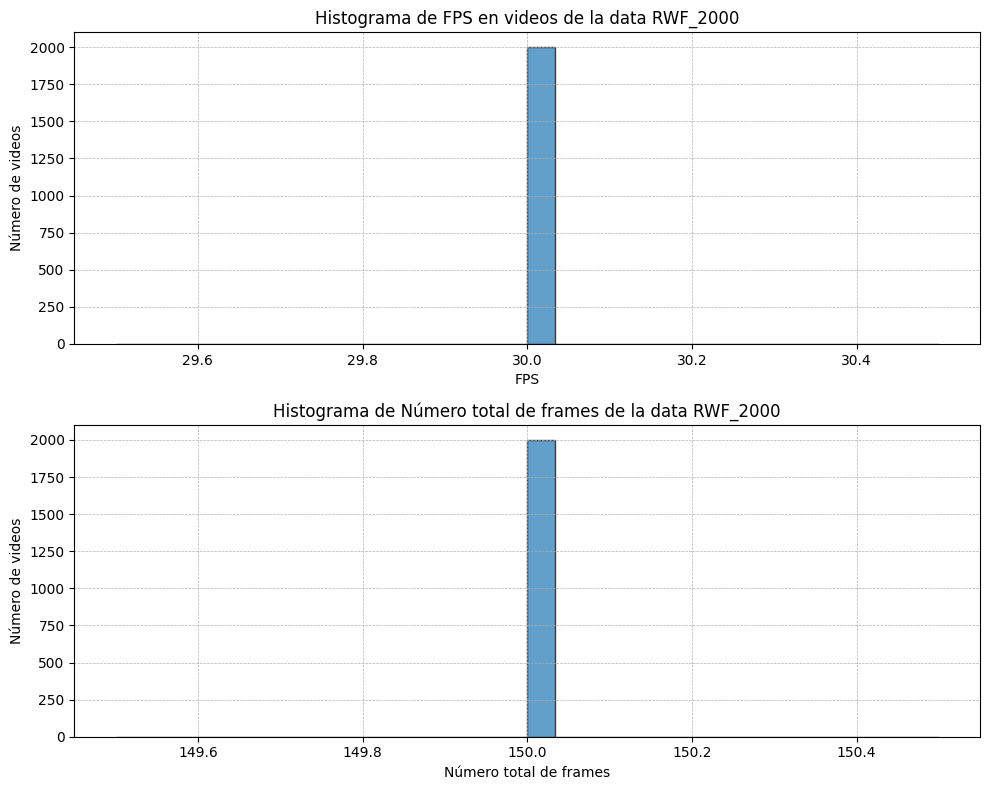

In [43]:
import matplotlib.pyplot as plt
list_fps,list_total_frames = histograms_in_videos(videos_RWF2000_df)
plot_histograms(list_fps, list_total_frames)


In [33]:

# **********************************************************************
# Se toma una muestra con una fracción de los datos del dataframe
# **********************************************************************

# Función para obtener un subconjunto aleatorio del DataFrame
def grupo_de_muestras(group, frac=0.10):
    return group.sample(frac=frac)

# Dividir el DataFrame según las variables 'etapa' y 'etiqueta' y aplicar la función grupo_de_muestras
muestra_RWF2000_df = videos_RWF2000_df.groupby(['data', 'etiqueta']).apply(grupo_de_muestras).reset_index(drop=True)
# Se elimina una variable que tiene muchas variables
del videos_RWF2000_df

muestra_RWF2000_df.describe()

,ruta,data,etiqueta
count,200,200,200
unique,200,2,2
top,/content/RWF-2000/train/Fight/FSaZ8wiFw8Q_0.avi,train,Fight
freq,1,160,100


In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os,time

def show_video(video_path, video_width = 600):
  video_name = video_path.split('/')[-1].split('.')[0]
  while not os.path.exists(f"/content/{video_name}.mp4"):
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}.mp4'".format(input=video_path, output=f"/content/{video_name}"))
    time.sleep(10)
  video_file = open(f"/content/{video_name}.mp4", "rb").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

def delete_video(video_path):
  video_name = video_path.split('/')[-1].split('.')[0]
  video_to_eliminate_path= f"/content/{video_name}.mp4"
  print(f"Se está eliminando el video: {video_name}")
  os.remove(video_to_eliminate_path)


In [ ]:
video_path = muestra_RWF2000_df[muestra_RWF2000_df["etiqueta"]=="Fight"]["ruta"].sample(1).to_list()[0]
show_video(video_path)

In [ ]:
delete_video(video_path)

Se está eliminando el video: xKq3hlefCUI_1


In [ ]:

def generate_heatmaps(video_path, output_folder, output_video_path):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_count = 0
    heatmap_frames = []

    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(gray_frame, prev_gray)

        normalized_diff = (frame_diff / np.max(frame_diff) * 255).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(normalized_diff, cv2.COLORMAP_JET)

        heatmap_path = os.path.join(output_folder, f'heatmap_{frame_count}.png')
        cv2.imwrite(heatmap_path, heatmap_color)
        heatmap_frames.append(heatmap_path)

        prev_gray = gray_frame
        frame_count += 1

    cap.release()

    # Convertir imágenes del heatmap en un video mp4
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for i in range(frame_count):
        frame = cv2.imread(heatmap_frames[i])
        out.write(frame)
    out.release()

# Generar heatmaps y un video mp4
generate_heatmaps(video_path, 'heatmaps_compressed', 'heatmap_video_compressed.mp4')


In [ ]:
import os
import subprocess
import ffmpeg

command = [
    'ffmpeg',
    '-i', 'heatmap_video_compressed.mp4',
    '-vcodec', 'h264',
    '-acodec', 'mp2',
    'output_compressed.mp4'
]
subprocess.run(command)


CompletedProcess(args=['ffmpeg', '-i', 'heatmap_video_compressed.mp4', '-vcodec', 'h264', '-acodec', 'mp2', 'output_compressed.mp4'], returncode=0)

In [ ]:
import os
import subprocess
import ffmpeg
video_width = 500
path="/content/output_compressed.mp4"
video_file = open(path,"rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
cap=cv2.VideoCapture(path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
fps

30

In [ ]:

def obtener_tensor(video_paths):
    videos = []
    for video_path in video_paths:
        # Abrir el video
        cap = cv2.VideoCapture(video_path)

        # Obtener las características del video
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = num_frames / fps

        # Definir la resolución y el número de canales deseados
        target_resolution = (224, 224)
        target_channels = 3

        # Inicializar un tensor para almacenar los frames redimensionados
        video_tensor = torch.empty((num_frames, target_channels, target_resolution[1], target_resolution[0]), dtype=torch.float32)

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Número de canales deseado
            if frame.shape[-1] != target_channels:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convertir a RGB si es necesario

            # Redimensionar el frame a la resolución deseada usando torch.nn.functional.interpolate
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0  # Cambiar formato y escalar
            frame = torch.nn.functional.interpolate(frame.unsqueeze(0), size=target_resolution, mode='bilinear', align_corners=False)
            frame = frame.squeeze(0)

            # Almacenar el frame en el tensor
            video_tensor[frame_idx] = frame
            frame_idx += 1

        # Liberar los recursos
        cap.release()

        # Agregar el tensor del video a la lista
        videos.append(video_tensor)

    tensor_torch = torch.stack(videos, dim=0)
    # Imprimir las dimensiones del tensor resultante
    print("Dimensiones del tensor resultante:", tensor_torch.shape)
    return tensor_torch


def obtener_labels(video_labels):
  # Crear un diccionario de mapeo de etiquetas a valores binarios (1 y 0)
  label_map = {'Fight': 1, 'NonFight': 0}

  # Convertir las etiquetas a valores binarios usando el mapeo
  binary_labels = [label_map[label] for label in video_labels]

  # Crear un tensor de PyTorch a partir de la lista de valores binarios
  tensor_labels = torch.tensor(binary_labels, dtype=torch.float32).to(torch.long)

  # Imprimir las dimensiones del tensor resultante
  print("Dimensiones del tensor resultante:", tensor_labels.shape)
  return tensor_labels

In [ ]:
train_video_paths = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='train']['ruta'])
train_video_labels = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='train']['etiqueta'])
# tensor_data = obtener_tensor()
train_videos = obtener_tensor(train_video_paths)
train_labels = obtener_labels(train_video_labels)

Dimensiones del tensor resultante: torch.Size([160, 150, 3, 224, 224])
Dimensiones del tensor resultante: torch.Size([160])


In [ ]:
test_video_paths = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='val']['ruta'])
test_video_labels = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='val']['etiqueta'])
# tensor_data = obtener_tensor()
test_videos = obtener_tensor(test_video_paths)
test_labels = obtener_labels(test_video_labels)

Dimensiones del tensor resultante: torch.Size([40, 150, 3, 224, 224])
Dimensiones del tensor resultante: torch.Size([40])


In [ ]:
train_data=TensorDataset(train_videos, train_labels)
test_data=TensorDataset(test_videos, test_labels)

# Entrenar el modelo

In [ ]:
%pip install einops
from torch import nn, einsum
import torch
from einops.layers.torch import Rearrange
from einops import rearrange, repeat


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FSAttention(nn.Module):
    """Factorized Self-Attention"""

    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class FDAttention(nn.Module):
    """Factorized Dot-product Attention"""

    def __init__(self, dim, nt, nh, nw, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.nt = nt
        self.nh = nh
        self.nw = nw

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, d, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        qs, qt = q.chunk(2, dim=1)
        ks, kt = k.chunk(2, dim=1)
        vs, vt = v.chunk(2, dim=1)

        # Attention over spatial dimension
        qs = qs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        ks, vs = ks.view(b, h // 2, self.nt, self.nh * self.nw, -1), vs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        spatial_dots = einsum('b h t i d, b h t j d -> b h t i j', qs, ks) * self.scale
        sp_attn = self.attend(spatial_dots)
        spatial_out = einsum('b h t i j, b h t j d -> b h t i d', sp_attn, vs)

        # Attention over temporal dimension
        qt = qt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        kt, vt = kt.view(b, h // 2, self.nh * self.nw, self.nt, -1), vt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        temporal_dots = einsum('b h s i d, b h s j d -> b h s i j', qt, kt) * self.scale
        temporal_attn = self.attend(temporal_dots)
        temporal_out = einsum('b h s i j, b h s j d -> b h s i d', temporal_attn, vt)

        # return self.to_out(out)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class FSATransformerEncoder(nn.Module):
    """Factorized Self-Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(nn.ModuleList(
                [PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
                 ]))

    def forward(self, x):

        b = x.shape[0]
        x = torch.flatten(x, start_dim=0, end_dim=1)  # extract spatial tokens from x

        for sp_attn, temp_attn, ff in self.layers:
            sp_attn_x = sp_attn(x) + x  # Spatial attention

            # Reshape tensors for temporal attention
            sp_attn_x = sp_attn_x.chunk(b, dim=0)
            sp_attn_x = [temp[None] for temp in sp_attn_x]
            sp_attn_x = torch.cat(sp_attn_x, dim=0).transpose(1, 2)
            sp_attn_x = torch.flatten(sp_attn_x, start_dim=0, end_dim=1)

            temp_attn_x = temp_attn(sp_attn_x) + sp_attn_x  # Temporal attention

            x = ff(temp_attn_x) + temp_attn_x  # MLP

            # Again reshape tensor for spatial attention
            x = x.chunk(b, dim=0)
            x = [temp[None] for temp in x]
            x = torch.cat(x, dim=0).transpose(1, 2)
            x = torch.flatten(x, start_dim=0, end_dim=1)

        # Reshape vector to [b, nt*nh*nw, dim]
        x = x.chunk(b, dim=0)
        x = [temp[None] for temp in x]
        x = torch.cat(x, dim=0)
        x = torch.flatten(x, start_dim=1, end_dim=2)
        return x


class FDATransformerEncoder(nn.Module):
    """Factorized Dot-product Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(
                PreNorm(dim, FDAttention(dim, nt, nh, nw, heads=heads, dim_head=dim_head, dropout=dropout)))

    def forward(self, x):
        for attn in self.layers:
            x = attn(x) + x

        return x


class ViViTBackbone(nn.Module):
    """ Model-3 backbone of ViViT """

    def __init__(self, t, h, w, patch_t, patch_h, patch_w, num_classes, dim, depth, heads, mlp_dim, dim_head=3,
                 channels=3, mode='tubelet', device='cuda', emb_dropout=0., dropout=0., model=3):
        super().__init__()

        assert t % patch_t == 0 and h % patch_h == 0 and w % patch_w == 0, "Video dimensions should be divisible by " \
                                                                           "tubelet size "

        self.T = t
        self.H = h
        self.W = w
        self.channels = channels
        self.t = patch_t
        self.h = patch_h
        self.w = patch_w
        self.mode = mode
        self.device = device

        self.nt = self.T // self.t
        self.nh = self.H // self.h
        self.nw = self.W // self.w

        tubelet_dim = self.t * self.h * self.w * channels

        self.to_tubelet_embedding = nn.Sequential(
            Rearrange('b c (t pt) (h ph) (w pw) -> b t (h w) (pt ph pw c)', pt=self.t, ph=self.h, pw=self.w),
            nn.Linear(tubelet_dim, dim)
        )

        # repeat same spatial position encoding temporally
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, self.nh * self.nw, dim)).repeat(1, self.nt, 1, 1)

        self.dropout = nn.Dropout(emb_dropout)

        if model == 3:
            self.transformer = FSATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)
        elif model == 4:
            assert heads % 2 == 0, "Number of heads should be even"
            self.transformer = FDATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)

        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        """ x is a video: (b, C, T, H, W) """

        tokens = self.to_tubelet_embedding(x)

        tokens += self.pos_embedding.to(device)
        tokens = self.dropout(tokens)

        x = self.transformer(tokens)
        x = x.mean(dim=1)

        x = self.to_latent(x)
        return self.mlp_head(x)


# if __name__ == '__main__':
#     device = torch.device('cuda')
#     x = torch.rand(32, 3, 32, 64, 64).to(device)

#     vivit = ViViTBackbone(32, 64, 64, 8, 4, 4, 10, 512, 6, 10, 8, model=3).to(device)
#     out = vivit(x)
#     print(out)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
### Métricas de evaluación
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve


# Funciones para métricas
def accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float()
    return correct.sum() / len(correct)

def average_precision(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred[:, 1]).detach().cpu().numpy()  # Suponemos que el índice 1 es la clase positiva
    y_true = y_true.cpu().numpy()
    return average_precision_score(y_true, y_pred)

def roc_curve_values(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred[:, 1]).detach().cpu().numpy()  # Suponemos que el índice 1 es la clase positiva
    y_true = y_true.cpu().numpy()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return fpr, tpr, thresholds


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0.05, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.stop = False
        self.delta = delta  # Cambio mínimo requerido (5% en este caso)

    def step(self, accuracy):
        score = accuracy
        if self.best_score is None:
            self.best_score = score
        # Si la mejora en precisión es menor que delta
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
                if self.verbose:
                    print(f"EarlyStopping activated. Best accuracy: {self.best_score:.4f}")
        else:
            self.best_score = score
            self.counter = 0

In [ ]:

# Configuración del modelo y del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Desactiva el benchmarking de cuDNN
torch.backends.cudnn.benchmark = False

num_epochs = 200
lr = 0.001
weight_decay= 0.0001
v = ViViTBackbone(
    t=150,
    h=224,
    w=224,
    patch_t=30,
    patch_h=14,
    patch_w=14,
    num_classes=2,  # Solo hay 2 clases: violencia y no violencia
    dim=128, #224
    depth=6,
    heads=10,
    mlp_dim=5,
    model=3
).to(device)

parameters = filter(lambda p: p.requires_grad, v.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Número de parámetros entrenables: %.3fM' % parameters)

early_stopping = EarlyStopping(patience=10, delta=0.1, verbose=True)

# Dividir en entrenamiento y prueba
# train_data = TensorDataset(train_videos, train_labels)
# test_data = TensorDataset(test_videos, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Función de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(v.parameters(), lr=lr, weight_decay=weight_decay)

# Entrenamiento
loss_values = []
val_loss_values = []

train_accuracy_values = []
val_accuracy_values = []

y_true = np.array([])
y_pred = np.array([])

out_epochs = 0

for epoch in range(num_epochs):
    v.train()
    avg_loss = 0
    num_batches = 0

    train_correct = 0
    train_total = 0

    for videos_batch, labels_batch in train_loader:
        videos_batch, labels_batch = videos_batch.to(device), labels_batch.to(device)
        videos_batch=videos_batch.permute(0, 2, 1, 3, 4)
        # Propagación hacia adelante

        predictions = v(videos_batch)

        loss = criterion(predictions, labels_batch)

        # Propagación hacia atrás y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        num_batches += 1

        _, train_predicted = torch.max(predictions.data, 1)
        train_total += labels_batch.size(0)
        train_correct += (train_predicted == labels_batch).sum().item()

    avg_loss /= num_batches
    loss_values.append(avg_loss)

    train_accuracy = 100 * train_correct / train_total
    train_accuracy_values.append(train_accuracy)



    # Evaluación en el conjunto de validación
    v.eval()
    val_loss = 0
    val_batches = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_videos_batch, val_labels_batch in test_loader:
            val_videos_batch, val_labels_batch = val_videos_batch.to(device), val_labels_batch.to(device)
            val_videos_batch=val_videos_batch.permute(0, 2, 1, 3, 4)
            val_predictions = v(val_videos_batch)
            val_loss_batch = criterion(val_predictions, val_labels_batch)
            val_loss += val_loss_batch.item()
            val_batches += 1
            _, predicted = torch.max(val_predictions.data, 1)
            total += val_labels_batch.size(0)
            correct += (predicted == val_labels_batch).sum().item()

            val_batches += 1

    val_loss /= val_batches
    val_loss_values.append(val_loss)

    val_accuracy = 100 * correct / total
    val_accuracy_values.append(val_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}, Validation Acc: {val_accuracy:.2f}%")
    #Llamada al EarlyStopping
    # early_stopping.step(train_accuracy)
    # if early_stopping.stop:
    #     print("Stopping training early!")
    #     break
    # out_epochs += 1

del videos_batch,labels_batch, val_videos_batch, val_labels_batch



Número de parámetros entrenables: 2.458M
Epoch [1/200], Train Loss: 1.0589, Validation Loss: 0.4647, Train Acc: 53.12, Validation Acc: 50.00%
Epoch [2/200], Train Loss: 0.7251, Validation Loss: 0.3309, Train Acc: 52.08, Validation Acc: 50.00%
Epoch [3/200], Train Loss: 0.7321, Validation Loss: 0.3348, Train Acc: 50.00, Validation Acc: 50.00%
Epoch [4/200], Train Loss: 0.6958, Validation Loss: 0.3768, Train Acc: 54.17, Validation Acc: 50.00%
Epoch [5/200], Train Loss: 0.7075, Validation Loss: 0.3453, Train Acc: 50.52, Validation Acc: 50.00%
Epoch [6/200], Train Loss: 0.6930, Validation Loss: 0.3294, Train Acc: 52.08, Validation Acc: 50.00%
Epoch [7/200], Train Loss: 0.6924, Validation Loss: 0.3383, Train Acc: 49.48, Validation Acc: 79.17%
Epoch [8/200], Train Loss: 0.6888, Validation Loss: 0.3409, Train Acc: 57.29, Validation Acc: 81.25%
Epoch [9/200], Train Loss: 0.6915, Validation Loss: 0.3299, Train Acc: 52.08, Validation Acc: 64.58%
Epoch [10/200], Train Loss: 0.6859, Validation Los

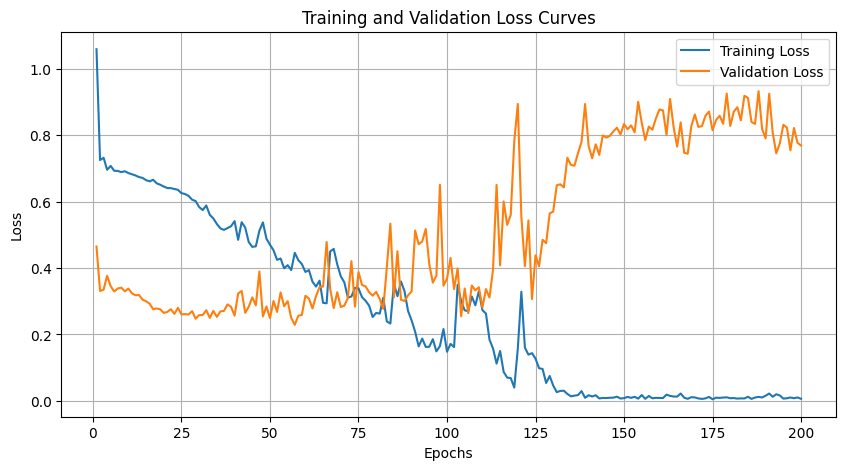

In [ ]:
# Gráfica de las curvas de pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, out_epochs+1), loss_values, label='Training Loss')
plt.plot(range(1, out_epochs+1), val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.grid(True)
plt.show()


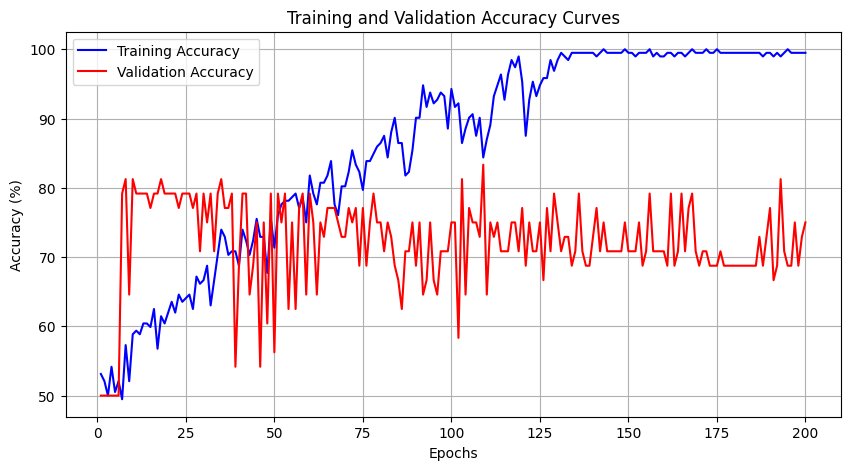

In [ ]:
# Gráfica de las curvas de accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, out_epochs+1), train_accuracy_values, label='Training Accuracy', color='blue')
plt.plot(range(1, out_epochs+1), val_accuracy_values, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy Curves')
plt.grid(True)
plt.show()